In [1]:
from pprint import pprint
import json
from IPython.display import display
from hamilton import driver

import __init__ as nixtla_statsforecast

/home/tjean/projects/dagworks/hamilton/contrib/hamilton/contrib/user/zilto/xgboost_optuna/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


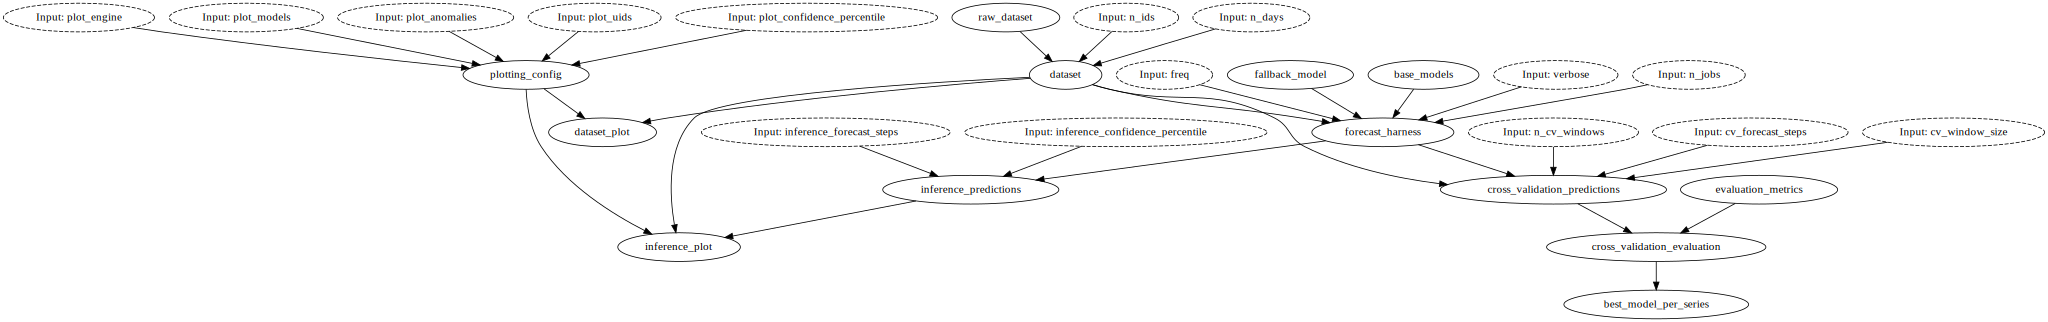

In [2]:
dr = (
    driver.Builder()
    .with_modules(nixtla_statsforecast)
    .build()
)

# create the DAG image
display(dr.display_all_functions(None))

In [3]:
final_vars = [v for v in dr.graph.get_nodes() if v._tags.get("module") == "__init__"]

inputs = dict()

overrides = dict()

res = dr.execute(
    final_vars=final_vars,
    inputs=inputs,
    overrides=overrides
)

pprint(list(res.keys()), width=1)

['base_models',
 'best_model_per_series',
 'cross_validation_evaluation',
 'cross_validation_predictions',
 'dataset',
 'dataset_plot',
 'evaluation_metrics',
 'fallback_model',
 'forecast_harness',
 'inference_plot',
 'inference_predictions',
 'plotting_config',
 'raw_dataset']
